In [10]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, ImageFile

#This is to handle corrupted images
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
#Nesting the directory because of the way the generator works
data_dir = os.path.join('..', 'data', 'scored')
labels_dir = os.path.join('..', 'data', 'scored.csv')
test_dir = os.path.join('.', 'data', 'val')

#This is used later with the batch size
num_train_imgs = len(os.listdir(data_dir))
num_test_imgs = len(os.listdir(os.path.join(test_dir,'query')))

#Just checking that no images are lost on the way
print("number of training images: ", num_train_imgs)
print("number of test images: ", num_test_imgs)

#Getting the indices in order of appearance from the directory and adding png for the generator
scores_df = pd.read_csv(labels_dir)
scores_df.reset_index(drop=True, inplace=True)
scores_df = scores_df.sort_values(by=['Id'])
scores_df['Id'] = scores_df['Id'].astype(str)+'.png'
scores_df

number of training images:  9600
number of test images:  1200


,Id,Actual
9264,1002900.png,2.631728
3920,1003620.png,1.560731
6953,1005208.png,3.137059
7129,1005849.png,3.509851
2528,1006237.png,1.371129
...,...,...
7083,9997019.png,1.561584
8160,9997923.png,3.291464
2776,9998327.png,0.971399
5146,9998462.png,1.890028


In [111]:
#Setting parameters
batch_size = 128
epochs = 15
IMG_HEIGHT = 250
IMG_WIDTH = 250

In [104]:
#scaling values to get intensity between 0 and 1
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

In [112]:
#Generator for our training data, it's being pulled from the dataframe
train_data_gen = train_image_generator.flow_from_dataframe(dataframe=scores_df, directory=data_dir, 
                                              x_col="Id", y_col="Actual", has_ext=True, 
                                              class_mode="other", target_size=(IMG_WIDTH, IMG_HEIGHT), 
                                              batch_size=batch_size)

Found 9600 validated image filenames.


In [113]:
#Generator for our query, this is the one that needs the directory to be nested
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=test_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1200 images belonging to 1 classes.


In [114]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation="linear")
])

In [115]:
model.compile(loss='MAE', optimizer='adam', metrics=['MSE'])

In [116]:
#Training
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=num_train_imgs // batch_size,
    epochs=epochs
)

Epoch 1/15
75/75 [==============================] - 221s 3s/step - loss: 0.7018 - MSE: 1.1763
Epoch 2/15
75/75 [==============================] - 216s 3s/step - loss: 0.6126 - MSE: 0.8146
Epoch 3/15
75/75 [==============================] - 208s 3s/step - loss: 0.5656 - MSE: 0.7341
Epoch 4/15
75/75 [==============================] - 201s 3s/step - loss: 0.5458 - MSE: 0.6939
Epoch 5/15
75/75 [==============================] - 204s 3s/step - loss: 0.4843 - MSE: 0.5764
Epoch 6/15
75/75 [==============================] - 209s 3s/step - loss: 0.4412 - MSE: 0.4906
Epoch 7/15
75/75 [==============================] - 210s 3s/step - loss: 0.3913 - MSE: 0.4030
Epoch 8/15
75/75 [==============================] - 210s 3s/step - loss: 0.3323 - MSE: 0.3093
Epoch 9/15
75/75 [==============================] - 210s 3s/step - loss: 0.3129 - MSE: 0.2638
Epoch 10/15
75/75 [==============================] - 123s 2s/step - loss: 0.2722 - MSE: 0.2065
Epoch 11/15
75/75 [==============================] - 58s 77

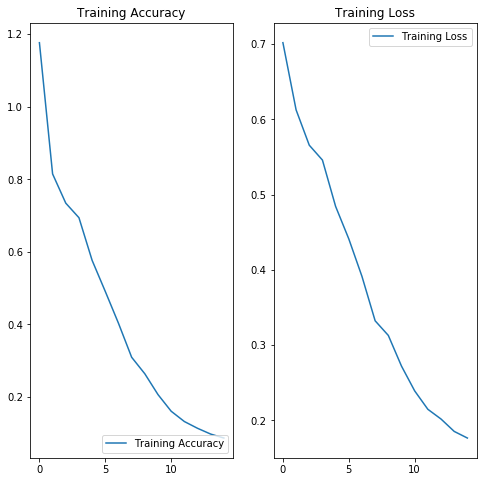

In [117]:
#Pulling some pretty graphs for training

acc = history.history['MSE']

loss=history.history['loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Loss')
plt.show()

In [118]:
#Getting predictions
predictions = model.predict(val_data_gen, verbose=1)
predictions

10/10 [==============================] - 29s 3s/step


array([[ 1.4703966 ],
       [ 1.2740372 ],
       [ 3.6399853 ],
       ...,
       [ 1.2997241 ],
       [-0.12104338],
       [ 2.3406813 ]], dtype=float32)

In [119]:
#Putting predictions in a pretty dataframe
predictions_file_ids = [x.replace('.png', '') for x in os.listdir(os.path.join(test_dir,'query'))]
results = {'Id': predictions_file_ids, 'Predicted': predictions.reshape(-1)}
results = pd.DataFrame(data=results)
results

,Id,Predicted
0,1000956,1.470397
1,1007209,1.274037
2,1016681,3.639985
3,1043763,2.592883
4,1051472,-0.004365
...,...,...
1195,9962129,1.487415
1196,9968166,2.620377
1197,9972585,1.299724
1198,9981103,-0.121043


In [120]:
#Preparing output for the kaggle submission
query_ex_path = os.path.join('..', 'data', 'query_example.csv')
query_ex = pd.read_csv(query_ex_path)
query_ex = query_ex.iloc[:,[0]]

query_ex = query_ex.astype(str)
results['Id'].astype(str)

query_preds = pd.merge(query_ex, results, on=['Id'])

query_preds.to_csv('out.csv', index=False)
query_preds

,Id,Predicted
0,7452475,0.554526
1,7071865,-0.001394
2,9302616,1.569059
3,7562317,1.131097
4,5940084,1.850995
...,...,...
1195,9022030,1.510219
1196,2640528,1.830043
1197,1114602,1.561953
1198,6934039,1.749473
